#  <center> Fluence map compression using wavelet basis </center>


In [1]:
!pip install -r requirements.txt

In [1]:
import sys
# sys.path.append('../../PortPy') 
sys.path.append('../')

In [2]:
import portpy.photon as pp
from compress_rtp.utils.get_low_dim_basis import get_low_dim_basis
import cvxpy as cp
import matplotlib.pyplot as plt

### 1) Accessing the portpy data using DataExplorer class
 Note: you first need to download the patient database from the link provided in the GitHub page.

In [3]:
# specify the patient data location.
data_dir = r'../../PortPy/data'

# Use PortPy DataExplorer class to explore PortPy data and pick one of the patient
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Patient_2'
data.patient_id = patient_id

# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

# If the list of beams are not provided, it uses the beams selected manually
# by a human expert planner for the patient (manually selected beams are stored in portpy data).
# Create beams for the planner beams by default
# for the customized beams, you can pass the argument beam_ids
# e.g. beams = pp.Beams(data, beam_ids=[0,10,20,30,40,50,60])
beams = pp.Beams(data)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
structs.create_opt_structures(opt_params=opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

# load clinical criteria from the config files for which plan to be optimized
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

Creating optimization structures.. It may take some time due to dilation
Optimization structures created!!
Creating BEV..
Loading sparse influence matrix...
Done


### 2) Optimizing the plan without quadratic smoothness (With and without wavelet constraint)
- Without wavelet constraint

In [4]:
# remove smoothness objective
for i in range(len(opt_params['objective_functions'])):
    if opt_params['objective_functions'][i]['type'] == 'smoothness-quadratic':
        opt_params['objective_functions'][i]['weight'] = 0

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()
sol_no_quad_no_wav = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 80.74087614579932
Elapsed time: 175.33836579322815 seconds


- With wavelet constraint

In [5]:
# creating the wavelet incomplete basis representing a low dimensional subspace for dimension reduction
wavelet_basis = get_low_dim_basis(inf_matrix=inf_matrix, compression='wavelet')
# Smoothness Constraint
y = cp.Variable(wavelet_basis.shape[1])
opt.constraints += [wavelet_basis @ y == opt.vars['x']]
sol_no_quad_with_wav = opt.solve(solver='MOSEK', verbose=False)

Running Optimization..
Optimal value: 84.88155072125934
Elapsed time: 265.50355887413025 seconds


### 3) Optimizing with quadratic smoothness ( With and without wavelet constraint)
- Without wavelet constraint

In [6]:
# set quadratic smoothness weight to 10
for i in range(len(opt_params['objective_functions'])):
    if opt_params['objective_functions'][i]['type'] == 'smoothness-quadratic':
        opt_params['objective_functions'][i]['weight'] = 10

# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
opt.create_cvxpy_problem()

# optimize the plan
sol_quad_no_wav = opt.solve(solver='MOSEK', verbose=False)

Objective Start
Objective done
Constraints Start
Constraints done
Running Optimization..
Optimal value: 83.09904940643341
Elapsed time: 170.08406114578247 seconds


- With Wavelet constraint

In [7]:
# Wavelet Smoothness Constraint
y = cp.Variable(wavelet_basis.shape[1])
opt.constraints += [wavelet_basis @ y == opt.vars['x']]
sol_quad_with_wav = opt.solve(solver='MOSEK', verbose=False)

Running Optimization..
Optimal value: 85.27181114227977
Elapsed time: 246.79305124282837 seconds


### 4) Saving and loading plan

In [8]:
# pp.save_plan(my_plan, plan_name='my_plan.pkl', path=r'C:\temp')
# pp.save_optimal_sol(sol_no_quad_no_wav, sol_name='sol_no_quad_no_wav.pkl', path=r'C:\temp')
# pp.save_optimal_sol(sol_no_quad_with_wav, sol_name='sol_no_quad_with_wav.pkl', path=r'C:\temp')
# pp.save_optimal_sol(sol_quad_no_wav, sol_name='sol_quad_no_wav.pkl', path=r'C:\temp')
# pp.save_optimal_sol(sol_quad_with_wav, sol_name='sol_quad_with_wav.pkl', path=r'C:\temp')

In [5]:
# my_plan = pp.load_plan(plan_name='my_plan', path=r'C:\temp')
# sol_no_quad_no_wav = pp.load_optimal_sol(sol_name='sol_no_quad_no_wav', path=r'C:\temp')
# sol_no_quad_with_wav = pp.load_optimal_sol(sol_name='sol_no_quad_with_wav', path=r'C:\temp')
# sol_quad_no_wav = pp.load_optimal_sol(sol_name='sol_quad_no_wav', path=r'C:\temp')
# sol_quad_with_wav = pp.load_optimal_sol(sol_name='sol_quad_with_wav', path=r'C:\temp')

### 5) Visualize and compare the plans

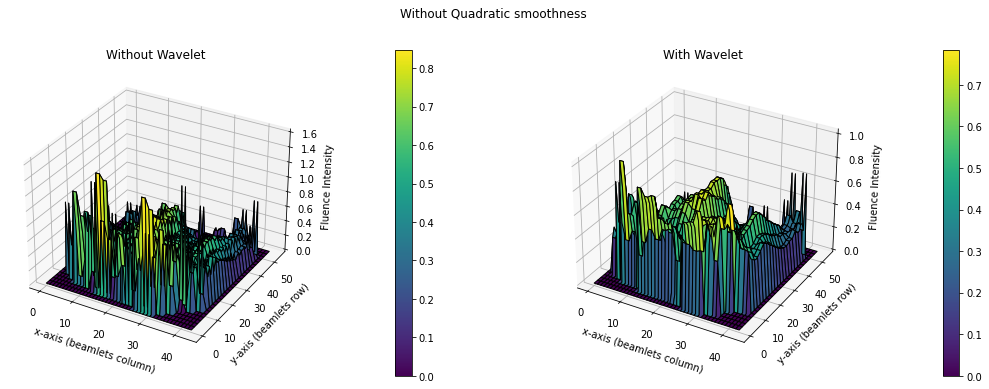

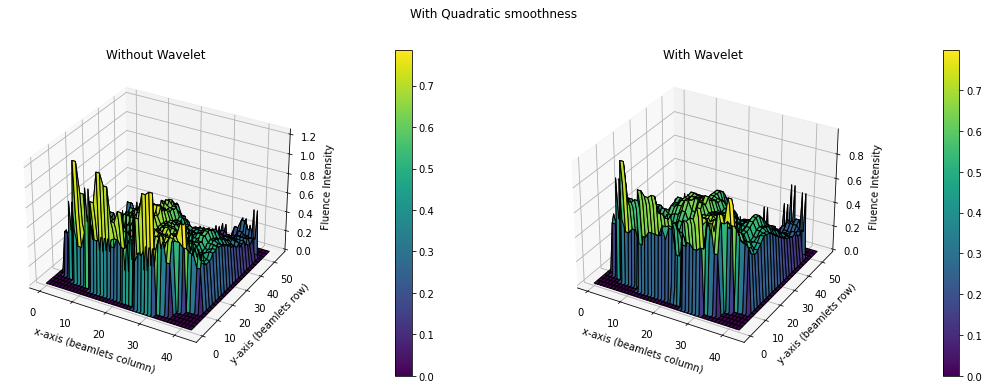

In [9]:
# plot fluence 3D and 2D
fig, ax = plt.subplots(1, 2, figsize=(18,6), subplot_kw={'projection': '3d'})
fig.suptitle('Without Quadratic smoothness')
pp.Visualization.plot_fluence_3d(sol=sol_no_quad_no_wav, beam_id=37, ax=ax[0], title='Without Wavelet')
pp.Visualization.plot_fluence_3d(sol=sol_no_quad_with_wav, beam_id=37, ax=ax[1], title='With Wavelet')

fig, ax = plt.subplots(1, 2, figsize=(18,6), subplot_kw={'projection': '3d'})
fig.suptitle('With Quadratic smoothness')
pp.Visualization.plot_fluence_3d(sol=sol_quad_no_wav, beam_id=37, ax=ax[0], title='Without Wavelet')
pp.Visualization.plot_fluence_3d(sol=sol_quad_with_wav, beam_id=37, ax=ax[1], title='With Wavelet')

plt.show()

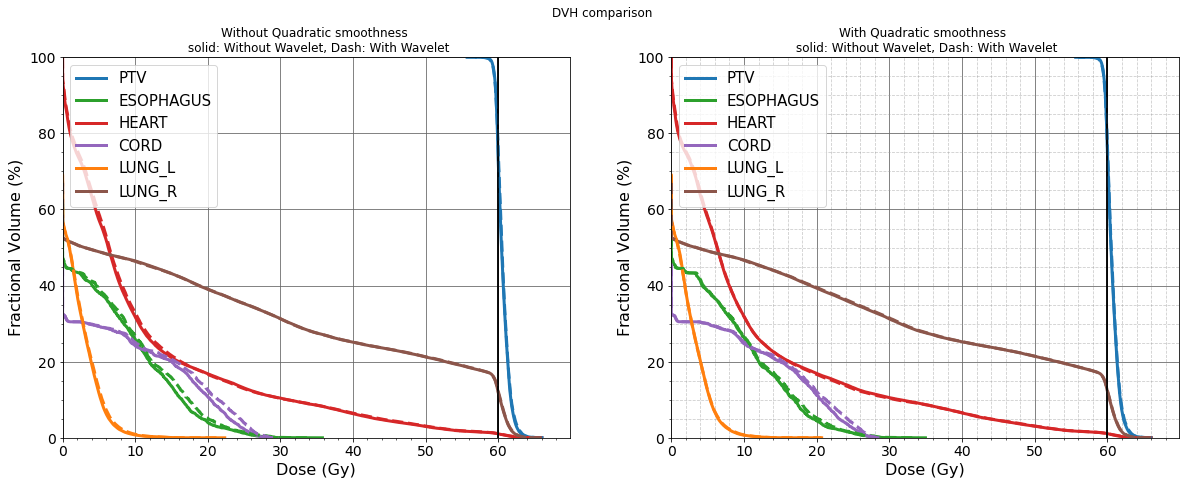

In [14]:
# plot DVH for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L', 'LUNG_R']
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax0 = pp.Visualization.plot_dvh(my_plan, sol=sol_no_quad_no_wav, struct_names=struct_names, style='solid', ax=ax[0])
ax0 = pp.Visualization.plot_dvh(my_plan, sol=sol_no_quad_with_wav, struct_names=struct_names, style='dashed', ax=ax0)
fig.suptitle('DVH comparison')
ax0.set_title('Without Quadratic smoothness \n solid: Without Wavelet, Dash: With Wavelet')
# plt.show()
# print('\n\n')

# fig, ax = plt.subplots(figsize=(12, 8))
ax1 = pp.Visualization.plot_dvh(my_plan, sol=sol_quad_no_wav, struct_names=struct_names, style='solid', ax=ax[1])
ax1 = pp.Visualization.plot_dvh(my_plan, sol=sol_quad_with_wav, struct_names=struct_names, style='dashed', ax=ax1)
ax1.set_title('With Quadratic smoothness \n solid: Without Wavelet, Dash: With Wavelet')
plt.show()


### 6) Evaluate the plans

In [11]:
# visualize plan metrics based upon clinical criteria
pp.Evaluation.display_clinical_criteria(my_plan, sol=[sol_no_quad_no_wav, sol_no_quad_with_wav, sol_quad_no_wav, sol_quad_with_wav], sol_names=['no_quad_no_wav', 'no_quad_with_wav', 'quad_no_wav', 'quad_with_wav'])

,constraint,structure_name,Limit,Goal,no_quad_no_wav,no_quad_with_wav,quad_no_wav,quad_with_wav
0,max_dose,GTV,69.0Gy,66.0Gy,64.96,65.20,64.94,65.24
1,max_dose,PTV,69.0Gy,66.0Gy,66.00,66.55,66.00,66.45
2,max_dose,ESOPHAGUS,66.0Gy,,35.79,34.32,34.95,33.81
3,mean_dose,ESOPHAGUS,34.0Gy,21.0Gy,5.25,5.52,5.36,5.49
4,V(60.0Gy),ESOPHAGUS,17.0%,,0.00,0.00,0.00,0.00
5,max_dose,HEART,66.0Gy,,66.00,66.00,66.00,66.00
6,mean_dose,HEART,27.0Gy,20.0Gy,10.85,11.03,10.92,10.92
7,V(30.0Gy),HEART,50.0%,,10.45,10.37,10.55,10.38
8,V(30.0Gy),HEART,,48.0%,10.45,10.37,10.55,10.38
9,max_dose,LUNG_L,66.0Gy,,22.33,21.79,20.67,20.66


In [23]:
# perform leaf sequencing for quadratic objective without and with wavelets using PortPy
leaf_seq_quad_no_wav = pp.leaf_sequencing_siochi(my_plan, sol_quad_no_wav)
leaf_seq_quad_wav = pp.leaf_sequencing_siochi(my_plan, sol_quad_with_wav)

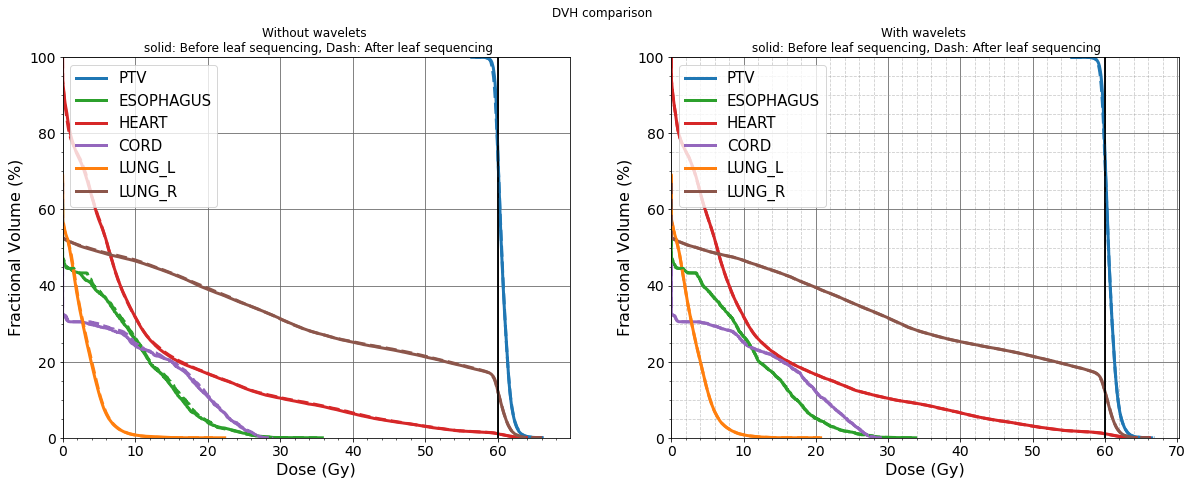

In [24]:
# Visualize the dvh after performing leaf sequencing using the optimal intensities
# plot DVH for the structures in the given list. Default dose_1d is in Gy and volume is in relative scale(%).
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD', 'LUNG_L', 'LUNG_R']
num_fractions = my_plan.get_num_of_fractions()
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax0 = pp.Visualization.plot_dvh(my_plan, sol=sol_no_quad_no_wav, struct_names=struct_names, style='solid', ax=ax[0])
ax0 = pp.Visualization.plot_dvh(my_plan, dose_1d=inf_matrix.A @ leaf_seq_quad_no_wav['optimal_intensity'] * num_fractions, struct_names=struct_names, style='dashed', ax=ax0)
fig.suptitle('DVH comparison')
ax0.set_title('Without wavelets \n solid: Before leaf sequencing, Dash: After leaf sequencing')
# plt.show()
# print('\n\n')

# fig, ax = plt.subplots(figsize=(12, 8))
ax1 = pp.Visualization.plot_dvh(my_plan, sol=sol_quad_with_wav, struct_names=struct_names, style='solid', ax=ax[1])
ax1 = pp.Visualization.plot_dvh(my_plan, dose_1d=inf_matrix.A @ leaf_seq_quad_wav['optimal_intensity'] * num_fractions, struct_names=struct_names, style='dashed', ax=ax1)
ax1.set_title('With wavelets \n solid: Before leaf sequencing, Dash: After leaf sequencing')
plt.show()

It can be noticed from the above figure that smoothing the fluence map using wavelets decreases the dose discrepancy between optimized and final deliverable plan